In [1]:
import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt

In [2]:
!pip install konlpy

In [4]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x2439fa03320>)

# 데이터 준비 & 전처리

In [10]:
df_train = pd.read_table('ratings_train.txt')
df_test = pd.read_table('ratings_test.txt')

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [13]:
# 1. 중복 데이터 제거
print(df_train['document'].nunique())
df_train = df_train.drop_duplicates(subset = ['document'])
print(df_train.nunique())

146182
id          146183
document    146182
label            2
dtype: int64


document가 다른 피쳐보다 1건 빠져있음 -> nan값이 존재함

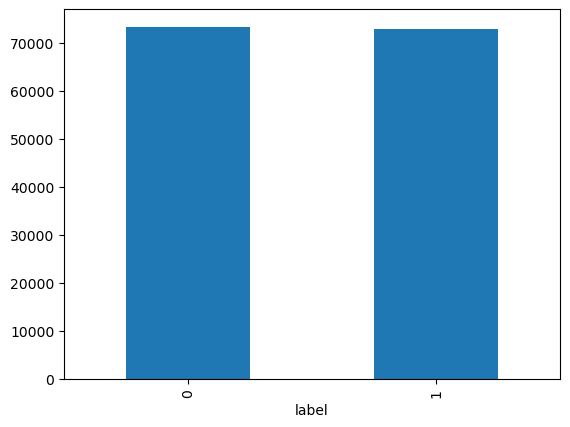

In [14]:
df_train['label'].value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
df_train = df_train.dropna(how = 'any')
df_train.isnull().values.sum() # 전체 데이터 프레임에서 NaN이 하나도 없음

0

In [21]:
import re

# 정규식을 활용해서 한글, 공백 한칸만 남기고 다 제거
df_train['document'] = df_train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "", regex=True)
df_train.head()

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1
